<h1 style="color: #002080; text-align: center;">Titanic Competition</h1>

<h2 style="color: #800000;">1- Import libraries and data</h2>

<h3><li style="color: #808000;">Import libraries:</li></h3>

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.compose import make_column_selector as selector
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from statistics import mode 

warnings.simplefilter(action='ignore')
numeric_columns = selector(dtype_include=np.number)
categorical_columns = selector(dtype_exclude=np.number)

<h3><li style="color: #808000;">Import data:</li></h3>

In [16]:
train_data = pd.read_csv('train.csv')
train_data.name = 'Train Dataset'
test_data = pd.read_csv('test.csv')
test_data.name = 'Test Dataset'

for dataset in [train_data,test_data]:
    display(dataset.head(5).style.set_caption("<h2>First 5 rows from "+dataset.name+"</h2>"))

In [17]:
for dataset in [train_data,test_data]:
    print('-'*20,dataset.name,'-'*20)
    print('  Shape : ', dataset.shape)
    print('  Number of non-numeric columns : ', len(categorical_columns(dataset)))
    print('  Total Number of null values : ', dataset.isnull().sum().sum())
    print('  Number of duplicated values : ', dataset.duplicated().sum())
    if 'label' in dataset.columns:
        print('  Unique values of "label" : ', sorted(list(dataset['label'].unique())))

-------------------- Train Dataset --------------------
  Shape :  (42000, 785)
  Number of non-numeric columns :  0
  Total Number of null values :  0
  Number of duplicated values :  0
  Unique values of "label" :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-------------------- Test Dataset --------------------
  Shape :  (28000, 784)
  Number of non-numeric columns :  0
  Total Number of null values :  0
  Number of duplicated values :  0


Let's plot the firet 25 rows in the train data:

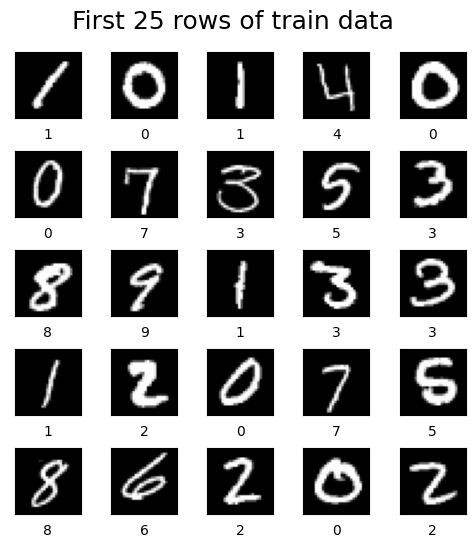

In [18]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(6, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("First 25 rows of train data", fontsize=18, y=0.95)

for i, ax in enumerate(axs.ravel()):
    pixels = train_data.drop('label', axis=1).iloc[i,:].to_numpy().reshape(28,28)
    ax.imshow(pixels, cmap='gray')
    ax.set(xticks=[], yticks=[], xlabel=str(train_data.iloc[i,0]))
plt.show()

And now, let's take a look in the count of the digits:

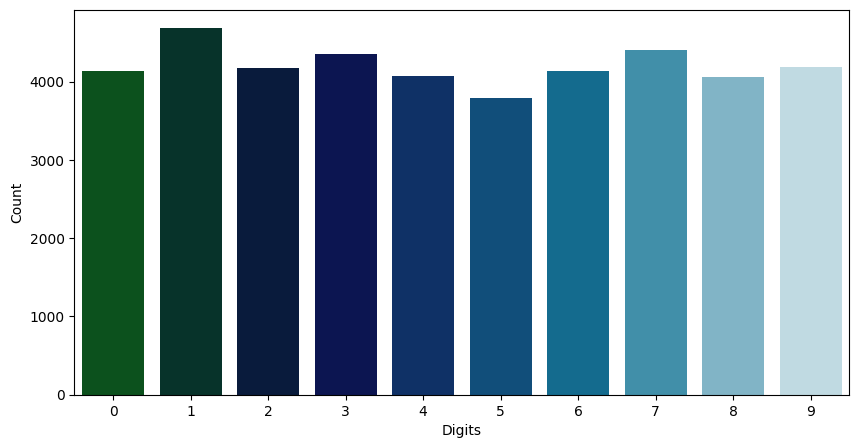

In [19]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_data, palette="ocean")
plt.xlabel('Digits')
plt.ylabel('Count')
plt.show()

Since everything is OK, and we don't need to do any pre-processing, let's move to the modeling part

<h2 style="color: #800000;">2- Modeling</h2>

In [20]:
X=train_data.drop('label', axis=1)
y=train_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

<h3><li style="color: #808000;">KNeighbors Classifier:</li></h3>

In [21]:
knn = KNeighborsClassifier()

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

0.9656349206349206

<h3><li style="color: #808000;">Random Forest Classifier:</li></h3>

In [22]:
forest = RandomForestClassifier()

forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

accuracy_score(y_test, y_pred)

0.9644444444444444

<h3><li style="color: #808000;">SVC:</li></h3>

In [23]:
svc = SVC()

svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

accuracy_score(y_test, y_pred)

0.9762698412698413

<h3><li style="color: #808000;">Logistic Regression:</li></h3>

In [24]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

accuracy_score(y_test, y_pred)

0.9161904761904762

<h3><li style="color: #808000;">Stack results:</li></h3>

In [25]:
estimators = [
    ('knn', KNeighborsClassifier()), 
    ('forest', RandomForestClassifier()), 
    ('svc', SVC()), 
]

stacking_classifier = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

stacking_classifier.fit(X_train, y_train)
stacking_test = stacking_classifier.predict(X_test)

accuracy_score(y_test, stacking_test)

0.9767460317460317

It seems like stacking the results of models gives better predictions, so we'll use the `stacking_classifier` to predict labels of the test dataset.

<h2 style="color: #800000;">3- Last step</h2>

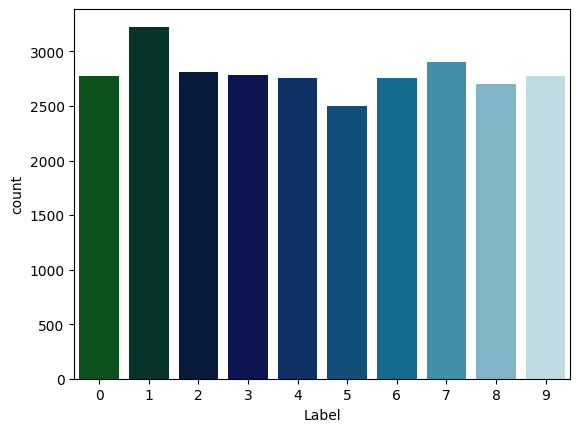

In [26]:
y_sub=stacking_classifier.predict(test_data)

submission = pd.DataFrame({
        "ImageId": [i+1 for i in range(len(test_data))],
        "Label": pd.Series(y_sub)
     })
submission['Label']=submission['Label'].astype('int8')
submission.to_csv('subm.csv', index=False)

pred_df = pd.read_csv('subm.csv')
sns.countplot(x='Label', data=pred_df, palette="ocean")
plt.show()